# Assignment 2

#### Student ID: *Double click here to fill the Student ID*

#### Name: *Double click here to fill the name*

Firstly, install the following dependencies:

In [ ]:
!pip install shap -qq
!pip install lime -qq
!pip install imodels -qq
!pip install pyngrok -qq
!pip install cleanlab -q
!pip install dtreeviz -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.5/195.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.8/175.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 8.1 MB/s eta 0:00:00


If you are using Colab or Kaggle notebook, try to install tensorflow-model-server and set up the tunnel using the following commands:

In [ ]:
import sys
from pyngrok import ngrok, conf
import getpass

if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    url = "https://storage.googleapis.com/tensorflow-serving-apt"
    src = "stable tensorflow-model-server tensorflow-model-server-universal"
    !echo 'deb {url} {src}' > /etc/apt/sources.list.d/tensorflow-serving.list
    !curl '{url}/tensorflow-serving.release.pub.gpg' | apt-key add -
    !apt update -q && apt-get install -y tensorflow-model-server
    %pip install -q -U tensorflow-serving-api

    print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
    conf.get_default().auth_token = getpass.getpass()

    # Setup a tunnel to the streamlit port 8050
    public_url = ngrok.connect(8050)

    print(public_url)

For this assignment, besides the labs, you may find the assignments in the previous offering useful https://phonchi.github.io/nsysu-math604/.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score

from sklearn.datasets import load_breast_cancer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.decomposition import PCA

import cleanlab
from cleanlab.classification import CleanLearning
from imodels import FIGSClassifier
from imodels.tree.viz_utils import extract_sklearn_tree_from_figs
import dtreeviz
import lime
import lime.lime_tabular
import shap

from pathlib import Path
import os 
import json
import requests

import logging
import warnings
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL) # For dtreeviz
warnings.filterwarnings("ignore", category=DeprecationWarning) # For shap

## Q1: Data cleaning with colic dataset

<center><img src="https://cdn.leonardo.ai/users/f26a2ba8-8273-45e9-8db9-958f83058486/generations/97af1bc3-e1b5-4c6a-84a7-3a8e7a37e97f/Default_Horse_medical_records_and_doctor_0.jpg"></center>

In this problem, we will deal with a colic dataset modified from https://www.kaggle.com/datasets/uciml/horse-colic from our customer. It presents the medical attributes of horses afflicted by colic, detailing their survival outcomes and comprises 300 instances and 26 input variables, along with a single output variable. We will predict whether the problem was surgical or not, making it a binary classification problem. Notably, a significant number of missing values appear across various columns, denoted by a question mark character ("?"). 

Firstly, execute the following code snippet for data preparation:

In [ ]:
# Function for comparing different approaches
def scoring_accuracy(X_train, X_valid, y_train, y_valid):
    model = RandomForestClassifier(random_state=2023)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return accuracy_score(y_valid, preds)

In [ ]:
data = pd.read_csv('colic.csv', na_values='?')
data.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


In [ ]:
# To keep things simple, we'll split the columns into numerical can categorical features
mapping_dict = {
    'no': 0,
    'yes': 1
}

data["surgical_lesion"] = data["surgical_lesion"].replace(mapping_dict)
y = data["surgical_lesion"]
data = data.drop("surgical_lesion", axis=1)
num_col = data.select_dtypes(exclude=['object'])
cat_col = data.select_dtypes(exclude=['int64','float64'])

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(data, y, train_size=0.8, test_size=0.2, random_state=0)
X_train_num = X_train.select_dtypes(exclude=['object'])
X_valid_num = X_valid.select_dtypes(exclude=['object'])
X_train_cat = X_train.select_dtypes(exclude=['int64','float64'])
X_valid_cat = X_valid.select_dtypes(exclude=['int64','float64'])

To ensure reproducibility, please set all the random seeds to 2023:

#### (a) To simplify the problem, we will consider only the numerical columns first. We will compare the model accuracy between the three data-cleaning approaches. (10%)

1. Replace missing values with the mean value along each column using `SimpleImputer()`.
2. Use the KNN imputation with 3 neighbors using `KNNImputer()`.
3. Use the iterative imputation method and set the regressor as Radnomforest using `IterativeImputer()`.

Use the `scoring_accuracy()` function provided above to perform classification and calculate the accuracy for each approach. Finally, make some comments on the results.

Hint: Since we are working with both training and validation sets, you should apply the same transform when you impute the missing value for both sets.

In [ ]:
# Imputation
my_imputer = SimpleImputer(strategy='mean')
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train_num))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid_num))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train_num.columns
imputed_X_valid.columns = X_valid_num.columns

print("MAE from Approach 1 (Imputation):")
print(scoring_accuracy(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE from Approach 1 (Imputation):
0.8666666666666667


In [ ]:
imp = KNNImputer(n_neighbors=3)
imputed_X_train = pd.DataFrame(imp.fit_transform(X_train_num))
imputed_X_valid = pd.DataFrame(imp.transform(X_valid_num))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train_num.columns
imputed_X_valid.columns = X_valid_num.columns

print("MAE from Approach 2 (Imputation):")
print(scoring_accuracy(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE from Approach 2 (Imputation):
0.8666666666666667


In [ ]:
 # You can also use other regressor as well (default is regularized linear regression)
est = RandomForestRegressor(random_state=2023)
imp = IterativeImputer(random_state=2023, estimator=est)
imputed_X_train = pd.DataFrame(imp.fit_transform(X_train_num))
imputed_X_valid = pd.DataFrame(imp.transform(X_valid_num))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train_num.columns
imputed_X_valid.columns = X_valid_num.columns

print("MAE from Approach 3 (Imputation):")
print(scoring_accuracy(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE from Approach 3 (Imputation):
0.8833333333333333


#### (b) Now, we will add categorical variables into consideration. Try to:

* Replace missing values with the most frequent value along each column for categorical variables. 
* Perform label (ordinal) encoding for the categorical variables. 
* When there are unknown categories in the validation set, set it to -1 for the label encoding.
* Use the best approach you found in (a) to impute the numerical column.

Combining the transformation above, which contains a separate numerical and categorical pipeline to the original training and validation data split (`X_train` and `X_valid`) and using the `scoring_accuracy()` function to calculate the accuracy. Make some comments on the results when comparing with (a). (10%)

Hint: Since we are working with both training and validation sets, try to apply the same transform when you impute the missing data or encode the variables. You may find [ColumnTransformer](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html), [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and the [`handle_unknown`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) option in the encoder useful.

In [ ]:
est = RandomForestRegressor(random_state=2023)
imp = IterativeImputer(random_state=2023, estimator=est)
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))]
)
numeric_transformer = Pipeline(
    steps=[("imputer", imp)]
)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, X_train_num.columns),
        ("cat", categorical_transformer, X_train_cat.columns),
    ]
)

In [ ]:
X_train_f = preprocessor.fit_transform(X_train)
X_valid_f = preprocessor.transform(X_valid)

In [ ]:
print(scoring_accuracy(X_train_f, X_valid_f, y_train, y_valid))

0.9166666666666666


#### (c) Use `CleanLearning` with `RandomForestClassifier` to fit the cleaned training you obtained in (b) (i.e., after imputation and encoding). Then, calculate the accuracy of the validation set. Finally, report the possible label issue in the training set using `cleanlab.dataset.health_summary()`. (10%)

In [ ]:
# For comparison, this is how you would have trained your model normally (without Cleanlab)
yourFavoriteModel = RandomForestClassifier(random_state=2023)
cl = cleanlab.classification.CleanLearning(yourFavoriteModel, seed=2023)

# Fit model to messy, real-world data, automatically training on cleaned data.
_ = cl.fit(X_train_f, y_train)

In [ ]:
# cl.score(X_valid_f, y_valid)
preds = cl.predict(X_valid_f)
accuracy_score(y_valid, preds)

0.9

In [ ]:
health = cleanlab.dataset.health_summary(
    y_train, confident_joint=cl.confident_joint
    # cleanlab uses the confident_joint internally to quantify label noise (see cleanlab.count.compute_confident_joint)
)

--------------------------------------------------------
|  Generating a Cleanlab Dataset Health Summary        |
|   for your dataset with 240 examples and 2 classes.  |
|  Note, Cleanlab is not a medical doctor... yet.      |
--------------------------------------------------------

Overall Class Quality and Noise across your dataset (below)
------------------------------------------------------------ 



,Class Index,Label Issues,Inverse Label Issues,Label Noise,Inverse Label Noise,Label Quality Score
0,0,11,5,0.120879,0.058824,0.879121
1,1,5,11,0.033557,0.070968,0.966443



Class Overlap. In some cases, you may want to merge classes in the top rows (below)
-----------------------------------------------------------------------------------



,Class Index A,Class Index B,Num Overlapping Examples,Joint Probability
0,0,1,16,0.066667



 * Overall, about 7% (16 of the 240) labels in your dataset have potential issues.
 ** The overall label health score for this dataset is: 0.93.

Generated with <3 from Cleanlab.



In [ ]:
# Additional code to check label quality
issues = CleanLearning(yourFavoriteModel, seed=2023).find_label_issues(X_train_f, y_train)
issues.sort_values(by=['label_quality'])

,is_label_issue,label_quality,given_label,predicted_label
195,True,0.01,1,0
3,True,0.01,0,1
199,True,0.02,0,1
26,True,0.04,0,1
1,True,0.12,1,0
...,...,...,...,...
81,False,0.98,0,0
234,False,0.98,0,0
122,False,0.99,0,0
0,False,0.99,1,1


## Q2. Feature engineering and selection with Ames housing dataset

In this question, we are going to examine several feature engineering and feature selection methods.

The dataset is from our previous project, which is a modified version of the Ames housing dataset. The original data was compiled by Dean De Cock for use in data science education and published in [De Cock, D. (2011)](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627). The modified version contains 2930 rows with 79 columns describing every aspect of residential homes in Ames, Iowa. The target of this problem is the `SalePrice`, while all the other columns are treated as features.

Firstly, execute the following code snippet for data preparation:

In [ ]:
# Function for comparing different approaches with cross validation
def score_dataset(X, y, pipeline):
    # See https://stats.stackexchange.com/questions/27750/feature-selection-and-cross-validation
    # , https://stackoverflow.com/questions/56308116/should-feature-selection-be-done-before-train-test-split-or-after
    # and https://stats.stackexchange.com/questions/2306/feature-selection-for-final-model-when-performing-cross-validation-in-machine

    # For simplicity, we perform label encoding for categoricals here, though it may be better to put it in pipline
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        pipeline, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

df = pd.read_csv("ames.csv")
X = df.copy()
y = X.pop('SalePrice')

X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,0.0,No_Pool,No_Fence,None,0.0,5,2010,WD,Normal
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,120.0,0.0,No_Pool,Minimum_Privacy,None,0.0,6,2010,WD,Normal
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,0.0,No_Pool,No_Fence,None,0.0,4,2010,WD,Normal
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,0.0,No_Pool,Minimum_Privacy,None,0.0,3,2010,WD,Normal


To ensure reproducibility, please set all the random seeds to 2023:

#### (a) The Ames dataset has a lot of features! Fortunately, you can identify the features with the most potential and use the filtering method. To start with, report the mutual information between the target and each feature in descending order using the `mutual_info_regression()` function on the original dataset `X`. Then, build a pipeline that selects the best 10 features and transforms the dataset using `SelectKBest()` function and fits the resulting dataset using Random forest. Calculate the RMSLE on the transformed dataset using the `score_dataset()`. (10%)


Hint: Since we are working with both training and validation sets, you may find [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) useful.

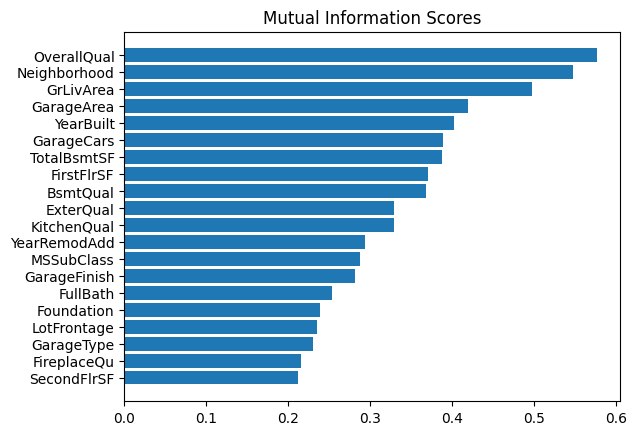

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()
# All discrete features should now have integer dtypes
mi_scores = mutual_info_regression(X, y, random_state=2023)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

plot_mi_scores(mi_scores.head(20))

In [ ]:
selecter = SelectKBest(mutual_info_regression, k=10).set_output(transform="pandas")
reg = RandomForestRegressor(random_state=2023)
# Create pipeline
pipeline_kbest = Pipeline([('selector', selecter), ('regressor', reg)])
score_dataset(X, y, pipeline_kbest)

0.16057295460730825

#### (b) Next, we'll rely on PCA to try to untangle the correlational structure of these features. Firstly, apply PCA on the dataset `X` and plot the cumulative explain variance using `pca()`. Then, build a pipeline that selects the number of components so that the cumulative explained variance is just above 90%  and fits the resulting dataset using Random forest. Calculate the RMSLE on the transformed dataset using the `score_dataset()`. (10%)

Hint: PCA is scale sensitive. Therefore, you must standardize the dataset before performing PCA by putting it into the pipeline. Since we are working with both training and validation sets, you may find [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) useful.

In [ ]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [ ]:
scale = StandardScaler()
X_scaled = scale.fit_transform(X)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [ ]:
### Additional code to check loadings
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78
0,2.471116,-2.922728,2.063824,0.388312,-2.665765,0.281691,-1.271660,0.939046,-0.159768,-0.247303,...,-0.183623,0.214287,0.405506,0.083929,-0.086473,-0.222175,-0.853664,-0.234533,-0.174601,3.719658e-14
1,-1.219128,-3.129935,-0.326267,-0.228285,-0.979814,0.567179,0.456698,1.093304,-0.848838,-0.376564,...,0.104074,0.558136,0.036739,0.296875,0.114278,0.392071,0.715813,0.161871,-1.122404,1.025913e-14
2,0.725499,-2.431194,2.607698,0.317762,-2.783788,-0.425053,0.472668,-0.310657,-0.858407,9.531325,...,-0.930333,-0.407014,-0.633678,-0.718061,0.111069,-0.427370,-0.066000,0.015561,-0.159059,7.558224e-15
3,3.897587,-0.416771,0.610692,0.875786,-2.396070,-0.140399,-0.587539,-0.899996,-0.532118,0.298247,...,-0.175806,0.492487,0.260669,-0.607016,-0.220413,-0.780388,0.085462,0.144901,-0.136716,-2.526780e-15
4,1.757106,-0.846158,-0.029185,-2.214761,1.441435,0.747769,0.398999,0.314968,-0.272761,0.203459,...,-0.268484,0.376691,-0.440468,-0.047057,0.401587,0.337461,0.337511,-0.044708,0.137239,9.869830e-15


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

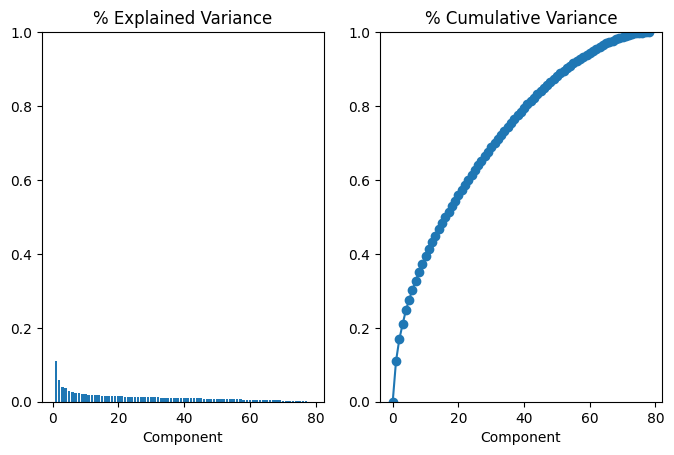

In [ ]:
# Look at explained variance
plot_variance(pca)

In [ ]:
# Create pipeline
pipeline_selectpca = Pipeline([("scale", StandardScaler()), ('pca', PCA(0.9)), ('regressor', reg)])
score_dataset(X, y, pipeline_selectpca)

(0.15737056254509585,)

#### (c) Finally, we will explore the embedding method. Try to build a pipeline that selects features using `SelectFromModel()` with the feature importance provided by `RandomForestRegressor` and fits the resulting dataset using Random forest. Then, calculate the RMSLE on the transformed dataset using the `score_dataset()`. Finally, comment on the results obtained by comparing it with (a) and (b). (10%)

Hint: You do not need to specify `threshold` or `max_features`; just use the default value to determine the number of features automatically. Since we are working with both training and validation sets, you may find [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) useful.

In [ ]:
reg = RandomForestRegressor(random_state=2023)
selecter = SelectFromModel(reg)
# Create pipeline
pipeline_selectmodel = Pipeline([('selector', selecter), ('regressor', reg)])
score_dataset(X, y, pipeline_selectmodel)

(0.1562812034678418,)

The result is slightly better than (a) and (b).

## Q3: Analyze breast cancer dataset with interpretable methods

Assume that there is a center that consults us to diagnose breast cancer and has digitized the images of the breast from around 570 patients. Features were computed from these digitized images that described the characteristics of cell nuclei in the images. For each cell nucleus, 10 features are used to describe its characteristics. For all the nuclei present in an image of a patient, the mean, standard error, and the largest or worst values are computed for each of these 10 features. Each patient, therefore, has 30 features in total. Given these input features, the goal of the system is to predict whether the cell is benign or malignant and to provide a confidence score for the doctor to help with their diagnosis.



Firstly, execute the following code snippet for data preparation:

In [ ]:
data = load_breast_cancer(as_frame=True)
X = data['data']
y = data['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=24)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=24)

In [ ]:
X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
416,9.405,21.70,59.60,271.2,0.10440,0.06159,0.02047,0.01257,0.2025,0.06601,...,10.85,31.24,68.73,359.4,0.1526,0.1193,0.06141,0.03770,0.2872,0.08304
389,19.550,23.21,128.90,1174.0,0.10100,0.13180,0.18560,0.10210,0.1989,0.05884,...,20.82,30.44,142.00,1313.0,0.1251,0.2414,0.38290,0.18250,0.2576,0.07602
438,13.850,19.60,88.68,592.6,0.08684,0.06330,0.01342,0.02293,0.1555,0.05673,...,15.63,28.01,100.90,749.1,0.1118,0.1141,0.04753,0.05890,0.2513,0.06911
304,11.460,18.16,73.59,403.1,0.08853,0.07694,0.03344,0.01502,0.1411,0.06243,...,12.68,21.61,82.69,489.8,0.1144,0.1789,0.12260,0.05509,0.2208,0.07638
218,19.800,21.56,129.70,1230.0,0.09383,0.13060,0.12720,0.08691,0.2094,0.05581,...,25.73,28.64,170.30,2009.0,0.1353,0.3235,0.36170,0.18200,0.3070,0.08255


To ensure reproducibility, please set all the random seeds to 2023:

#### (a) First, fit an interpretable model and show doctors some evidence the model is doing something in line with their medical intuition. (10%)

* Try to build a `FIGSClassifier()` decision rule model as a baseline and calculate the accuracy of the model on the validation set. Set the parameter [`max_rule`](https://csinva.io/imodels/tree/figs.html) to 5.
* Draw the feature importance plot using the [feature_importances_](https://csinva.io/imodels/tree/figs.html#imodels.tree.figs.FIGS.feature_importances_) and find out the most important feature.
* Now, a patient (The data is recorded in the first row in the test dataset with id `331`) comes in, and he/she would like to know why he/she got (or does not get) breast cancer. Use the rule generated from the model to give him/her some reasons. You may also use a tree to visualize the decision path.

In [ ]:
# specify a decision tree with a maximum depth
figs = FIGSClassifier(max_rules = 5, random_state=2023)
figs.fit(X_train, y_train, feature_names=data.feature_names)

# calculate mse on the training data
probs = figs.predict_proba(X_val)
preds = figs.predict(X_val)

print("Classifier Accuracy:", np.mean(y_val == preds), "\n Learned interpretable model:\n", figs)

Classifier Accuracy: 0.9764705882352941 
 Learned interpretable model:
 > ------------------------------
> FIGS-Fast Interpretable Greedy-Tree Sums:
> 	Predictions are made by summing the "Val" reached by traversing each tree.
> 	For classifiers, a sigmoid function is then applied to the sum.
> ------------------------------
worst area <= 884.550 (Tree #0 root)
	worst concave points <= 0.166 (split)
		worst concave points <= 0.136 (split)
			Val: 0.979 (leaf)
			worst texture <= 28.615 (split)
				Val: 0.833 (leaf)
				Val: 0.000 (leaf)
		Val: 0.000 (leaf)
	mean texture <= 15.015 (split)
		Val: 0.800 (leaf)
		Val: 0.017 (leaf)



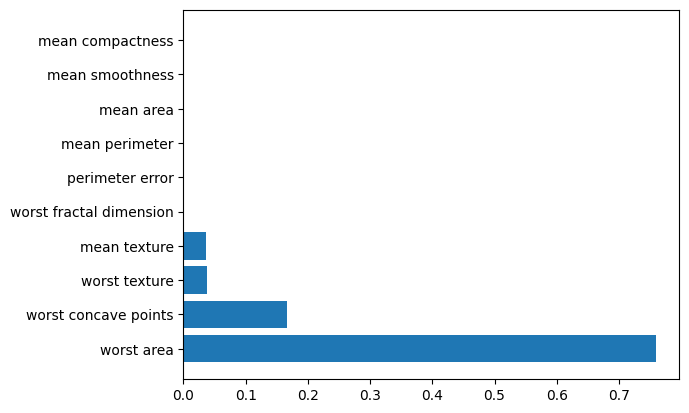

In [ ]:
importances = figs.feature_importances_

indices = np.argsort(importances)[::-1][:10]

fig, ax = plt.subplots()
ax.barh(range(len(indices)), importances[indices])
ax.set_yticks(range(len(indices)))
_ = ax.set_yticklabels(np.array(X.columns)[indices])

In [ ]:
X_test

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
331,12.98,19.35,84.52,514.0,0.09579,0.11250,0.07107,0.02950,0.1761,0.06540,...,14.42,21.95,99.21,634.3,0.1288,0.32530,0.34390,0.09858,0.3596,0.09166
266,10.60,18.95,69.28,346.4,0.09688,0.11470,0.06387,0.02642,0.1922,0.06491,...,11.88,22.94,78.28,424.8,0.1213,0.25150,0.19160,0.07926,0.2940,0.07587
507,11.06,17.12,71.25,366.5,0.11940,0.10710,0.04063,0.04268,0.1954,0.07976,...,11.69,20.74,76.08,411.1,0.1662,0.20310,0.12560,0.09514,0.2780,0.11680
153,11.15,13.08,70.87,381.9,0.09754,0.05113,0.01982,0.01786,0.1830,0.06105,...,11.99,16.30,76.25,440.8,0.1341,0.08971,0.07116,0.05506,0.2859,0.06772
437,14.04,15.98,89.78,611.2,0.08458,0.05895,0.03534,0.02944,0.1714,0.05898,...,15.66,21.58,101.20,750.0,0.1195,0.12520,0.11170,0.07453,0.2725,0.07234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,20.47,20.67,134.70,1299.0,0.09156,0.13130,0.15230,0.10150,0.2166,0.05419,...,23.23,27.15,152.00,1645.0,0.1097,0.25340,0.30920,0.16130,0.3220,0.06386
124,13.37,16.39,86.10,553.5,0.07115,0.07325,0.08092,0.02800,0.1422,0.05823,...,14.26,22.75,91.99,632.1,0.1025,0.25310,0.33080,0.08978,0.2048,0.07628
531,11.67,20.02,75.21,416.2,0.10160,0.09453,0.04200,0.02157,0.1859,0.06461,...,13.35,28.81,87.00,550.6,0.1550,0.29640,0.27580,0.08120,0.3206,0.08950
78,20.18,23.97,143.70,1245.0,0.12860,0.34540,0.37540,0.16040,0.2906,0.08142,...,23.37,31.72,170.30,1623.0,0.1639,0.61640,0.76810,0.25080,0.5440,0.09964


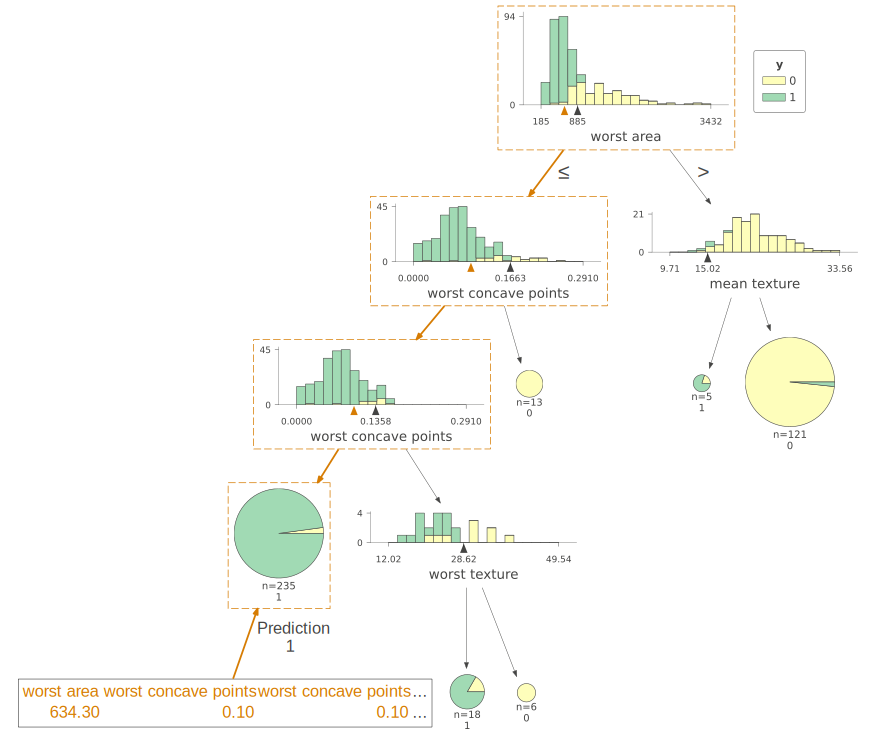

In [ ]:
### Check the patients
dt = extract_sklearn_tree_from_figs(figs, tree_num=0, n_classes=2) # tree_num =  0 or 1
viz_model = dtreeviz.model(dt,
                           X_train=X_train, y_train=y_train,
                           feature_names=data.feature_names,
                           target_name='y', class_names=[0, 1])
x_example = X_test.iloc[0]
viz_model.view(x=x_example, scale=1.5)

When the worst area of cell is larger, the patient has higher chance to be malignant. Since patients worst area = 634.3 which is smaller than the first decision point (884.550). Therefore, it is predicted as benign.

#### (b) The doctor is glad you convinced the patients and would like to know more. It appears `worst area` of the cell is a critical feature, and the doctors would like to know more about that. (10%)

* Divide the original data `X` into two datasets, Benign (Target equals 1) and Malignant (Target equals 0), respectively. Draw the distribution of the `worst area` for these two datasets.
* Create a partial dependence plot for them that shows how `worst area` of the cell affects the model's predictions. (You should use the validation set to generate the plot)
* Comment on your results based on the previous two items about how `worst area` of the cell affect the predictions. Is it consistent with the results from (a)?

Text(0.5, 1.0, 'Worst Cell Area Distribution')

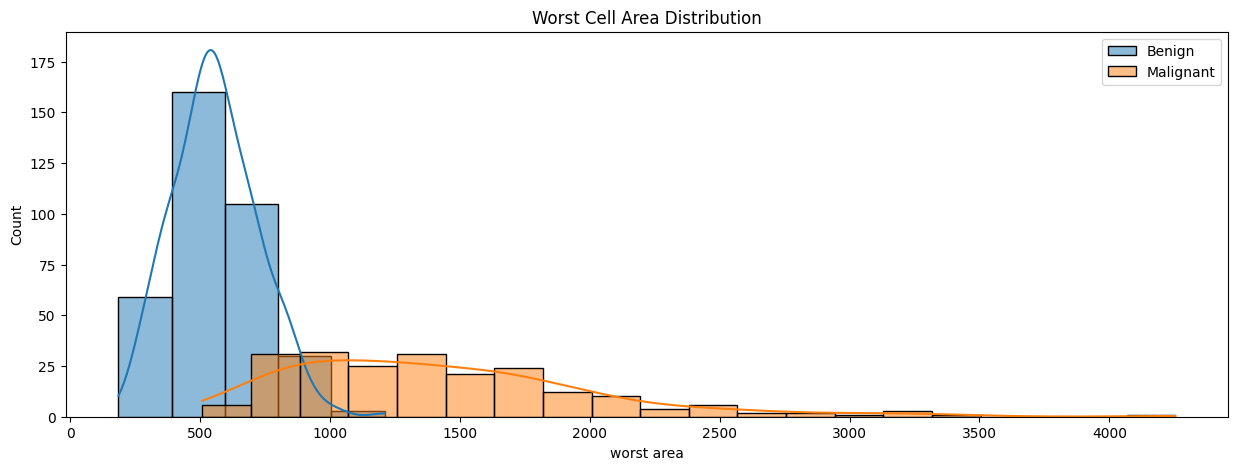

In [ ]:
df_benign = X[y == 1].reset_index(drop=True)
df_malignant = X[y == 0].reset_index(drop=True)
f, ax = plt.subplots(1, 1, figsize=(15, 5))

sns.histplot(df_benign, bins=5, ax=ax, label='Benign', x = 'worst area', kde=True)
sns.histplot(df_malignant, bins=20, ax=ax, label='Malignant', x = 'worst area', kde=True)
ax.legend()
ax.set_title('Worst Cell Area Distribution')

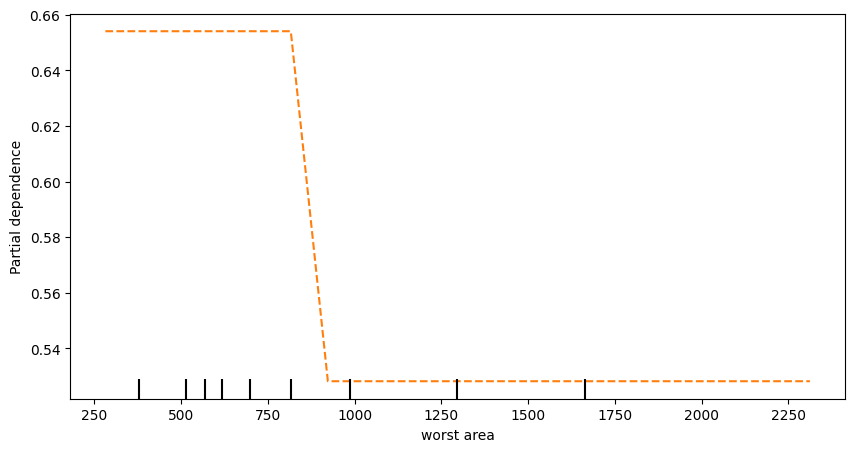

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
features = ["worst area"]
display = PartialDependenceDisplay.from_estimator(
    figs,
    X_val,
    features,
    grid_resolution=20,
    random_state=2023,
    pd_line_kw={"color": "tab:orange", "linestyle": "--"}
)

display.figure_.subplots_adjust(hspace=0.3)

From the distrubtion plot, when the worst area of cell is larger, the patient has higher chance to be malignant. The partial dependence plot also shows that when worst area is larger, the probability of benign is smaller.

#### (c) The doctor is glad about the results, but he/she is still worried about the model performance of the model you just built.  (5%)

* Try to build a more complicated classifier based on a deep neural network (DNN) and train it using the following code. 
* Then report the accuracy on the validation set and test set.
* Find out the patients that the model is most confident and least confident based on the probability from `model.predict()`, and report their index.

In [ ]:
tf.keras.utils.set_random_seed(2023)
# Create a sequential model
model = models.Sequential()

# Add layers to the model
model.add(layers.Dense(20, input_dim=30, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Display the model summary
model.summary()

# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model for 300 epochs and track the history
num_epochs = 300
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_val, y_val), verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                620       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 891
Trainable params: 891
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
13/13 [==============================] - 8s 40ms/step - loss: 125.7226 - accuracy: 0.6307 - val_loss: 96.5410 - val_accuracy: 0.6118
Epoch 2/300
13/13 [==========================

In [ ]:
predicted_prob = model.predict(X_test)
predicted_label = (predicted_prob > 0.5).astype(int)

3/3 [==============================] - 0s 3ms/step


In [ ]:
accuracy_score(y_test, predicted_label)

0.9418604651162791

In [ ]:
## Additional code to check against baseline
baseline = np.array([1 for _ in range(len(y_test))])
precision = precision_score(y_test, predicted_label)
p_baseline = precision_score(y_test, baseline)
r_baseline = recall_score(y_test, baseline)
recall = recall_score(y_test, predicted_label)
f1 = f1_score(y_test, predicted_label)
f1_baseline = f1_score(y_test, baseline)
print('Precision: ', precision, 'Recall: ', recall, 'F1: ', f1)
print('(Baseline) Precision: ', p_baseline, 'Recall: ', r_baseline, 'F1: ', f1_baseline)

Precision:  0.9454545454545454 Recall:  0.9629629629629629 F1:  0.9541284403669724
(Baseline) Precision:  0.627906976744186 Recall:  1.0 F1:  0.7714285714285715


In [ ]:
idx = np.argsort(predicted_prob, axis=0)

In [ ]:
benign_idx = idx[-1][0]
malignant_idx = idx[0][0]

benign_idx, malignant_idx

(30, 74)

#### (d) Use Lime and Shap to explain the two patients you find in (c)
* Create the [`lime_tabular.LimeTabularExplainer()`](https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_tabular) and use [`explain_instance()`](https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_tabular.LimeTabularExplainer.explain_instance) to explain the two instance. Then, draw the local explanation for these two instances by showing the most important five features.
* Create the [`KernelExplainer()`](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html#) using `shap` with the following argument, where `prob` is also defined below:  (15%)

```python
KernelExplainer(prob, X_train.to_numpy(), link="logit")

def prob(data):
    return model.predict(data).reshape(-1, 1)
```
* Using the above [`KernelExplainer()`](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html#) to explain the two instances by calculating the shap value and draw the force plots for them using [`shap.force_plot()`](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.force_plot.html). You can set the parameter [`nsamples`](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html#shap.KernelExplainer.shap_values) to 100 to speed up the calculation.
* Based on the results of `lime` and `shap` explain why these two patients got (or does not get) breast cancer. Do the results consistent with (a) and (b)?

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(), feature_names=data.feature_names, class_names=data.target_names, discretize_continuous=True)

In [ ]:
def prob(data):
    return model.predict(data)

In [ ]:
bc1_lime = explainer.explain_instance(X_test.to_numpy()[benign_idx], prob, num_features=5, top_labels=1)

157/157 [==============================] - 0s 2ms/step



                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


Text(0.5, 1.0, 'Benign Case 1 (DNN Confidence: 100%) | Kernel Width = None (Score: 0.40)')

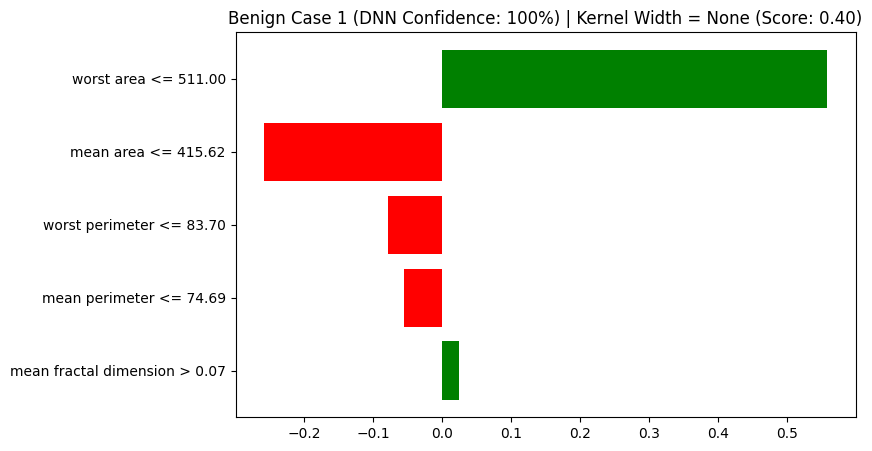

In [ ]:
def lime_exp_as_pyplot(exp, label=0, figsize=(8,5)):
    exp_list = exp.as_list(label=label)
    fig, ax = plt.subplots(figsize=figsize)
    vals = [x[1] for x in exp_list]
    names = [x[0] for x in exp_list]
    vals.reverse()
    names.reverse()
    colors = ['green' if x > 0 else 'red' for x in vals]
    pos = np.arange(len(exp_list)) + .5
    ax.barh(pos, vals, align='center', color=colors)
    plt.yticks(pos, names)
    return fig, ax

f, ax = lime_exp_as_pyplot(bc1_lime)
ax.set_title('Benign Case 1 (DNN Confidence: %d%%) | Kernel Width = None (Score: %.2f)' % (round(float(predicted_prob[benign_idx]) * 100), bc1_lime.score))

157/157 [==============================] - 0s 2ms/step



                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


Text(0.5, 1.0, 'Malignant Case 1 (DNN Confidence: 11%) | Kernel Width = None (Score: 0.43)')

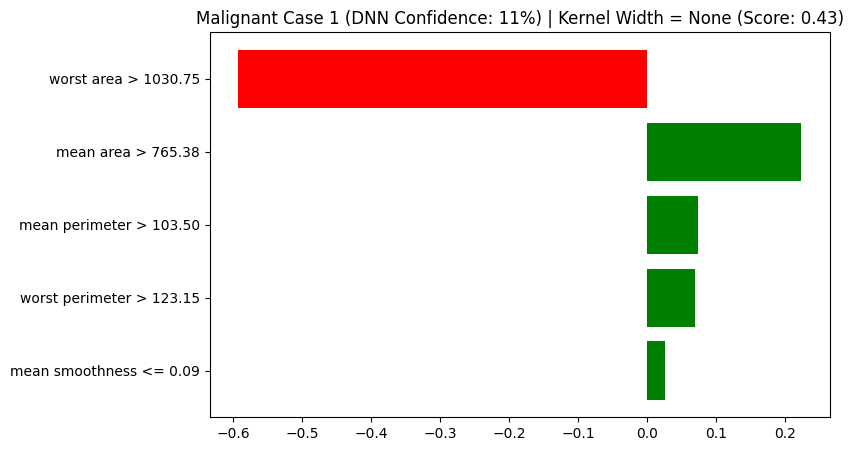

In [ ]:
exp = explainer.explain_instance(X_test.to_numpy()[malignant_idx], prob, num_features=5, top_labels=1)
f, ax = lime_exp_as_pyplot(exp)
ax.set_title('Malignant Case 1 (DNN Confidence: %d%%) | Kernel Width = None (Score: %.2f)' % (round(float(predicted_prob[malignant_idx]) * 100), exp.score))

In [ ]:
#file_path="/usr/local/lib/python3.9/dist-packages/shap/explainers/_permutation.py"
#!sed -i '214s/warnings.warn("shap_values() is deprecated; use __call__().", warnings.DeprecationWarning)/warnings.warn("shap_values() is deprecated; use __call__().", DeprecationWarning)/' "$file_path"

In [ ]:
shap_explainer = shap.KernelExplainer(prob, X_train.to_numpy(), link="logit")
shap_values = shap_explainer.shap_values(X_test.to_numpy()[benign_idx], nsamples=100)

13/13 [==============================] - 0s 2ms/step


1244/1244 [==============================] - 2s 1ms/step


In [ ]:
shap.initjs()
shap.force_plot(shap_explainer.expected_value[0], shap_values[0], X_test.to_numpy()[benign_idx], feature_names=data['feature_names'], link="logit")

In [ ]:
shap_explainer = shap.KernelExplainer(prob, X_train.to_numpy(), link="logit")
shap_values = shap_explainer.shap_values(X_test.to_numpy()[malignant_idx], nsamples=100)

13/13 [==============================] - 0s 2ms/step


1244/1244 [==============================] - 2s 2ms/step


In [ ]:
shap.initjs()
shap.force_plot(shap_explainer.expected_value[0], shap_values[0], X_test.to_numpy()[malignant_idx], feature_names=data['feature_names'], link="logit")

The lime and force plot demonstrates that when worst area is larger, the chance of malignant is larger. The results are consistent with previous questions.

#### (e) Now, the doctors are convinced you have the right data, and the model overview looks reasonable. It's time to turn this into a finished product they can use. (10%)
* Try to use `tf.keras.models.save_model()` to save your DNN model.
* Deploy your model as a REST API server using TensorFlow Serving with `tensorflow_model_server`. 
* Test your server by sending a request that contains the data of the previous two patients using `json.dumps()` and `requests.post()`. Show that the responses from the server are close to the predictions of the original model for these two patients using [`np.isclose()`](https://numpy.org/doc/stable/reference/generated/numpy.isclose.html).

Hint: Notice that the input to the DNN model should be with shape `(number of samples, number of features)` even if you feed a single instance.

In [ ]:
model_name = "my_breast_model"
model_version = "0001"
model_path = Path(model_name) / model_version


tf.keras.models.save_model(
    model,
    model_path,
    overwrite=True,
    include_optimizer=True,
    save_format="tf",
    signatures=None,
    options=None
)

In [ ]:
### Additional code to check the save model
for root, dirs, files in os.walk(model_name):
    indent = '    ' * root.count(os.sep)
    print('{}{}/'.format(indent, os.path.basename(root)))
    for filename in files:
        print('{}{}'.format(indent + '    ', filename))

my_breast_model/
    0001/
        fingerprint.pb
        saved_model.pb
        keras_metadata.pb
        assets/
        variables/
            variables.data-00000-of-00001
            variables.index


In [ ]:
os.environ["MODEL_DIR"] = str(model_path.parent.absolute())

In [ ]:
%%bash --bg
nohup tensorflow_model_server \
     --port=8500 \
     --rest_api_port=8050 \
     --model_name=my_breast_model \
     --model_base_path="${MODEL_DIR}" > server.log 2>&1

In [ ]:
!pgrep tensorflow

8902


In [ ]:
X_test.to_numpy()[benign_idx].reshape(-1,30).shape

(1, 30)

In [ ]:
input_data_json = json.dumps({
    "signature_name": "serving_default",
    "instances": X_test.to_numpy()[benign_idx].reshape(-1,30).tolist()
})

In [ ]:
SERVER_URL = 'http://localhost:8050/v1/models/my_breast_model:predict'
response = requests.post(SERVER_URL, data=input_data_json)
response.raise_for_status() # raise an exception in case of error
response = response.json()

In [ ]:
model.predict(X_test.to_numpy()[benign_idx].reshape(-1,30))[0][0]

1/1 [==============================] - 0s 40ms/step


0.9998667

In [ ]:
np.isclose(response['predictions'][0][0], model.predict(X_test.to_numpy()[benign_idx].reshape(-1,30))[0][0])

1/1 [==============================] - 0s 29ms/step


True

In [ ]:
input_data_json = json.dumps({
    "signature_name": "serving_default",
    "instances": X_test.to_numpy()[malignant_idx].reshape(-1,30).tolist()
})

SERVER_URL = 'http://localhost:8050/v1/models/my_breast_model:predict'
response = requests.post(SERVER_URL, data=input_data_json)
response.raise_for_status() # raise an exception in case of error
response = response.json()

In [ ]:
response['predictions'][0][0]

0.11135789

In [ ]:
np.isclose(response['predictions'][0][0], model.predict(X_test.to_numpy()[malignant_idx].reshape(-1,30))[0][0])

1/1 [==============================] - 0s 108ms/step


True

In [ ]:
!kill 5487